# Exercice 3: Mise en place de notre modèle

Nous allons utiliser la bibliothèque ```spacy``` afin d'entraîner un modèle sur les données fournies. 

In [9]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy_irrelevant, format_data_as_spacy_others, format_data_as_spacy
from src.spacy_helper import get_spacy_irrelevant_model, get_spacy_others_model, get_spacy_model
from src.spacy_helper import train, predict, predict_with_threshold

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [10]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)


model = get_spacy_model(labels)

model = train(model, X_train, y_train, 10, test=(X_test, y_test))
model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 17.557886948547093 test score:33.8205123795496%
Iteration 1/10. train_loss: 1.1272987709380686 test score:50.7599195310894%
Iteration 2/10. train_loss: 0.2602892027789494 test score:60.76921091190843%
Iteration 3/10. train_loss: 0.09190115301680635 test score:64.16767558102411%
Iteration 4/10. train_loss: 0.043081295403681 test score:74.27092261419345%
Iteration 5/10. train_loss: 0.029742525109213602 test score:76.46929362355098%
Iteration 6/10. train_loss: 0.024116580358167994 test score:74.18358368923886%
Iteration 7/10. train_loss: 0.019116747017960734 test score:76.98910838498212%
Iteration 8/10. train_loss: 0.01684062191088742 test score:75.63414111403506%
Iteration 9/10. train_loss: 0.014020922134818647 test score:76.57097278918697%


In [11]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [12]:
testing_results = score(y_true, y_pred)

In [13]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.62      0.60      0.61        67
      find-flight       0.69      0.92      0.79        24
       find-hotel       0.72      0.76      0.74        55
  find-restaurant       0.81      0.77      0.79        93
       find-train       0.74      0.81      0.77        21
       irrelevant       0.90      0.90      0.90       677
provide-showtimes       0.73      0.79      0.76        14
         purchase       0.81      0.73      0.76       114

         accuracy                           0.84      1065
        macro avg       0.75      0.78      0.77      1065
     weighted avg       0.84      0.84      0.84      1065



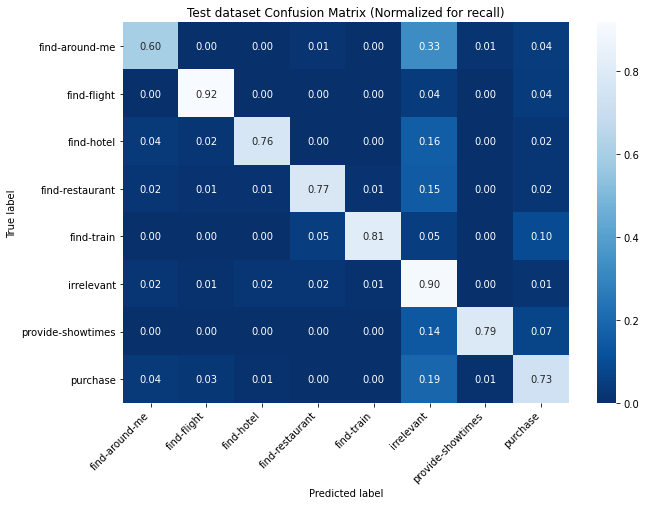

In [14]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

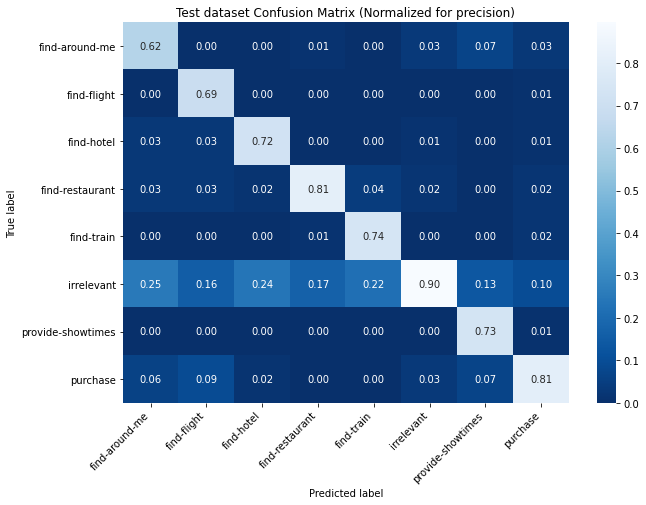

In [15]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On observe une précision presque identique au modèle d'origine néanmoins on remarquera que nous avons grandement amélioré le recall.
Cela nous intéresse puisque cette amélioration se traduit par une plus grande proportion d'intentions qui sont correctement décelées.
Les deux métriques tournent autour de 0.7-0.8 ce qui semble être un bon seuil d'utilisation afin d'avoir une expéreicne eutilisteur satisfaisante.
Plus concrètement, cela veut dire que l'utilisateur aura moins de frustration lorsqu'il tentera de lancer une action basée sur une intention, puisqu'auparavant il avait statistiquement 50% de chances que son intention soit reconnue, alors que maintenant il en a 70%.
Malgré tout, nous voulons faire en sorte d'essayer d'améliorer la précision qui reste un point déterminant de l'expérience utilisateur dans ce cas d'utilisation.
Pour y remédier, nous tentons alors de modifier notre prise de décision sur le retour du modèle en instaurant une fonction de seuil, qui introduit un pourcentage de certitude pour attribuer un label hors "irrelevant" au lieu de prendre la plus haute probabilité.

In [16]:
training_results = score(y_true_t, y_pred_t)

In [17]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.98      0.97      0.98       383
      find-flight       0.89      0.99      0.94       142
       find-hotel       0.99      0.98      0.99       316
  find-restaurant       0.98      0.99      0.98       469
       find-train       0.96      0.99      0.97       143
       irrelevant       1.00      0.99      0.99      3852
provide-showtimes       0.97      0.99      0.98       117
         purchase       0.99      0.97      0.98       613

         accuracy                           0.99      6035
        macro avg       0.97      0.98      0.98      6035
     weighted avg       0.99      0.99      0.99      6035



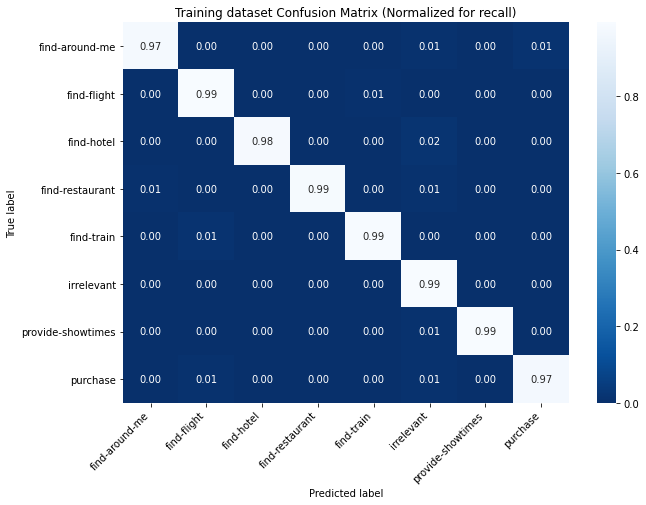

In [18]:
cm_testing_metrics = np.array(training_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Training dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [19]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.5, "irrelevant")


In [20]:
testing_results_thresh = score(y_true, y_pred_thresh)

In [21]:
print(testing_results_thresh['report'])

                   precision    recall  f1-score   support

   find-around-me       0.67      0.60      0.63        67
      find-flight       0.71      0.92      0.80        24
       find-hotel       0.74      0.76      0.75        55
  find-restaurant       0.81      0.77      0.79        93
       find-train       0.74      0.81      0.77        21
       irrelevant       0.88      0.91      0.89       677
provide-showtimes       0.79      0.79      0.79        14
         purchase       0.81      0.69      0.75       114

         accuracy                           0.84      1065
        macro avg       0.77      0.78      0.77      1065
     weighted avg       0.84      0.84      0.84      1065



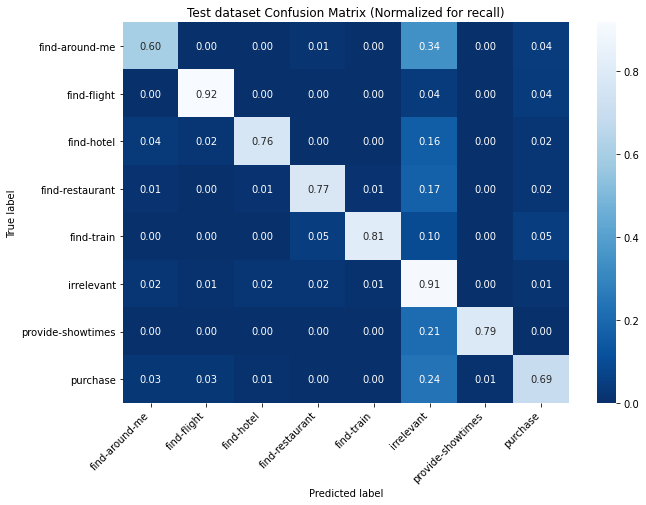

In [22]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

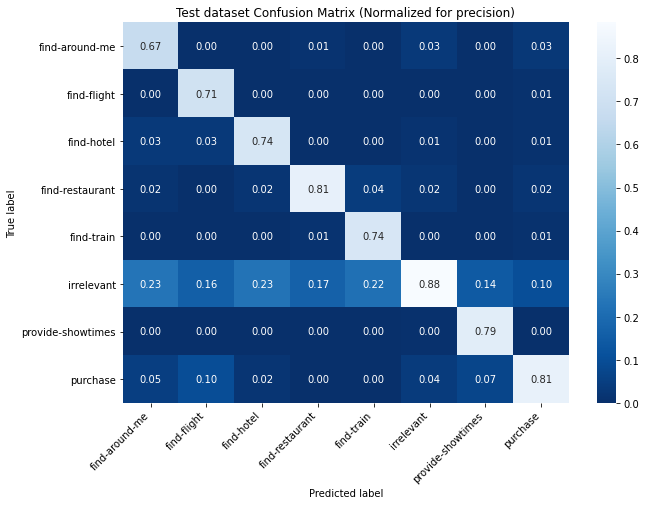

In [23]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On remarque que lorsqu'on fixe un threshold assez faible, à 0.5, les résultats sont identiques, ce qui indique que notre modèle fait ses choix avec une confiance assez importante.

In [24]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.75, "irrelevant")
y_pred_t_thresh = predict_with_threshold(model, X_train, 0.75, "irrelevant")
training_results_thresh = score(y_true_t, y_pred_t_thresh)
testing_results_thresh = score(y_true, y_pred_thresh)
print(testing_results_thresh['report'])

                   precision    recall  f1-score   support

   find-around-me       0.75      0.49      0.59        67
      find-flight       0.77      0.83      0.80        24
       find-hotel       0.78      0.73      0.75        55
  find-restaurant       0.88      0.75      0.81        93
       find-train       0.74      0.81      0.77        21
       irrelevant       0.85      0.93      0.89       677
provide-showtimes       0.79      0.79      0.79        14
         purchase       0.85      0.64      0.73       114

         accuracy                           0.84      1065
        macro avg       0.80      0.75      0.77      1065
     weighted avg       0.84      0.84      0.83      1065



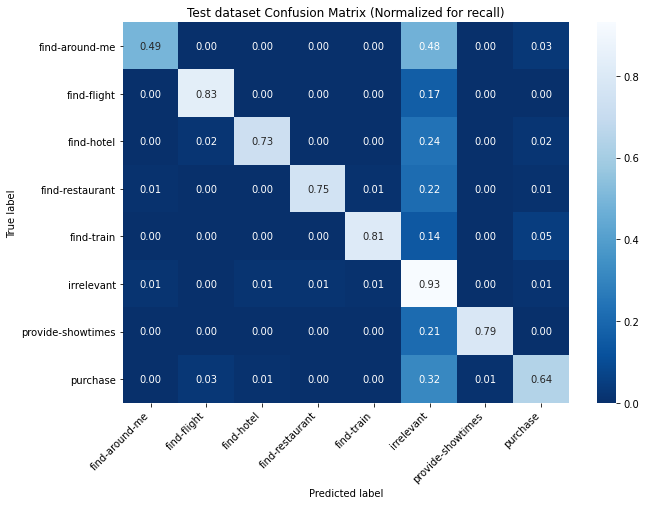

In [25]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

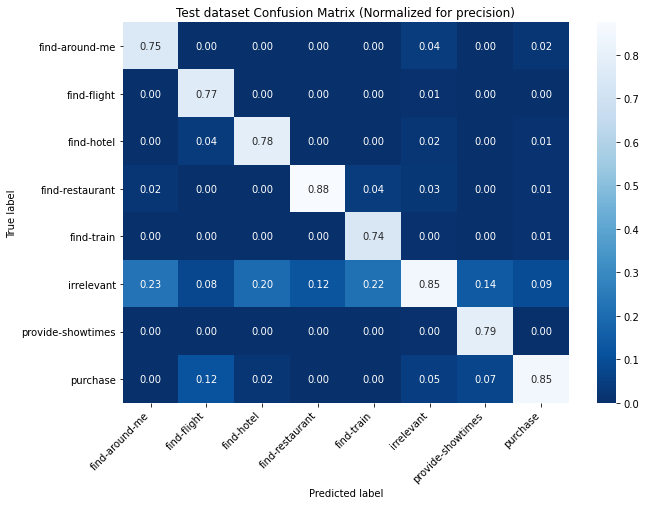

In [26]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

En essayant de monter le threshold à 0.75, on observe une légère amélioration de la précision sur l'ensemble des classes (hors 'irrelevant'), mais cette précision est contrebalancée par une diminution du recall. Nous préférons donc continuer avec le threshold à 0.5 .

# Avec le jeu de données augmenté

Le training set a été augmenté pour certaines classes, de nouveaux exemples sont produits à partir des anciens exemples.
Ces nouveaux exemples sont générés en remplaçant les mots de type 'verbe' et 'nom' par les lemmes de leurs synonymes.
Nous pensons que bien que cela nous ne offre pas de meilleures performances sur le training set et le test set, si l'on arrive à garder les anciennnes performances, cela indiquera que ntore modèle est plus robuste.

In [27]:
raw_training_data = get_raw_training_data('./data/augmented_training_set.json')

for r in raw_training_data:
    if "message" in r:
        r["sentence"] = r["message"]

y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)

model = get_spacy_model(labels)

model = train(model, X_train, y_train, 18, test=(X_test, y_test))
model.to_disk(f"./model_augmented")

Training the model...
Iteration 0/18. train_loss: 20.21989798708819 test score:46.71318956391104%
Iteration 1/18. train_loss: 0.9096401146380231 test score:64.6358762828826%
Iteration 2/18. train_loss: 0.1735619736937224 test score:68.6688220683447%
Iteration 3/18. train_loss: 0.05192569520295365 test score:73.29052634217338%
Iteration 4/18. train_loss: 0.03321777720884711 test score:73.32918913912107%
Iteration 5/18. train_loss: 0.022208019751587926 test score:75.44539226455794%
Iteration 6/18. train_loss: 0.018032194905515553 test score:74.38323725399772%
Iteration 7/18. train_loss: 0.014289087403795975 test score:75.62883365735591%
Iteration 8/18. train_loss: 0.013471609057120304 test score:75.00097969137767%
Iteration 9/18. train_loss: 0.01180515468561083 test score:75.50492242183823%
Iteration 10/18. train_loss: 0.00817968077778275 test score:74.6464349192961%
Iteration 11/18. train_loss: 0.00821787751917391 test score:74.99850347199629%
Iteration 12/18. train_loss: 0.008353071164

In [28]:
y_pred = predict(model, X_test)

In [29]:
testing_results = score(y_true, y_pred)

In [30]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.60      0.67      0.63        67
      find-flight       0.67      0.75      0.71        24
       find-hotel       0.70      0.76      0.73        55
  find-restaurant       0.84      0.82      0.83        93
       find-train       0.65      0.81      0.72        21
       irrelevant       0.92      0.89      0.91       677
provide-showtimes       0.75      0.64      0.69        14
         purchase       0.75      0.80      0.77       114

         accuracy                           0.85      1065
        macro avg       0.74      0.77      0.75      1065
     weighted avg       0.85      0.85      0.85      1065



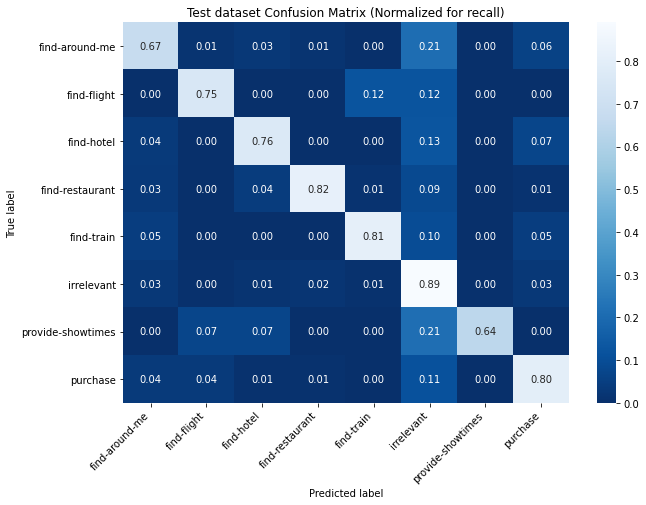

In [31]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

Les performances que nous obtenons avec ce modèle ne semblent pas nécessairement meilleures que celle de notre modèle d'origine. Cependant, nous supposons que celui-ci serait capable de mieux généraliser pour des exemples sortant du dataset.

Nous avons également essayé de mettre en place de la classification hiérarchique en créant 2 modèles au lieu d'un seul : le premier attribuant le label "irrelevant" ou non. Si le label "irrelevant" n'est pas attribué, on donne alors la donnée au deuxième modèle qui lui attribue un label associé à une des classes d'intérêt.

In [32]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy_irrelevant(raw_training_data)
X_test, y_test = format_data_as_spacy_irrelevant(raw_testing_data)


irrelevant_model = get_spacy_irrelevant_model(labels)


irrelevant_model = train(irrelevant_model, X_train, y_train, 10, test=(X_test, y_test))
irrelevant_model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 11.609187685775396 test score:83.7823021517002%
Iteration 1/10. train_loss: 0.6210499948647339 test score:84.15488509753538%
Iteration 2/10. train_loss: 0.12329008859524038 test score:84.60080972268125%
Iteration 3/10. train_loss: 0.04057385434771277 test score:86.03760843053607%
Iteration 4/10. train_loss: 0.024255048356735642 test score:86.14515301889922%
Iteration 5/10. train_loss: 0.012857222542152158 test score:85.06345331594748%
Iteration 6/10. train_loss: 0.011734590556443436 test score:85.60679315963392%
Iteration 7/10. train_loss: 0.009812260638796033 test score:86.23005430401119%
Iteration 8/10. train_loss: 0.008658023370884393 test score:86.77208042848163%
Iteration 9/10. train_loss: 0.007885101336228217 test score:85.6225566997764%


In [33]:
raw_training_data_others = [r for r in raw_training_data if r['intent'] != "irrelevant"]
raw_testing_data_others = [r for r in raw_testing_data if r['intent'] != "irrelevant"]

others_y_true = [r['intent'] for r in raw_testing_data if r['intent'] != "irrelevant"]
others_y_true_t = [r['intent'] for r in raw_training_data if r['intent'] != "irrelevant"]

X_train, y_train = format_data_as_spacy_others(raw_training_data_others)
X_test, y_test = format_data_as_spacy_others(raw_testing_data_others)

others_model = get_spacy_others_model(labels)

others_model = train(others_model, X_train, y_train, 10, test=(X_test, y_test))
others_model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 17.83854111097753 test score:52.80011568964039%
Iteration 1/10. train_loss: 3.074539798531532 test score:69.61096819059385%
Iteration 2/10. train_loss: 0.9321482967061456 test score:80.50760764184128%
Iteration 3/10. train_loss: 0.3308713479746075 test score:82.13122430348338%
Iteration 4/10. train_loss: 0.13275793935827096 test score:84.175155882437%
Iteration 5/10. train_loss: 0.060201128698281536 test score:85.92864464407451%
Iteration 6/10. train_loss: 0.026079974162939834 test score:86.61535951790152%
Iteration 7/10. train_loss: 0.01632436483788524 test score:87.05697706099268%
Iteration 8/10. train_loss: 0.009101122977043019 test score:88.13329727247849%
Iteration 9/10. train_loss: 0.005441254802803996 test score:86.4701603852492%


In [34]:
X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)

y_pred_irr = predict(irrelevant_model, X_test)
y_pred_t_irr = predict(irrelevant_model, X_train)

X_train = [X_train[i] for i in range(len(X_train)) if y_pred_t_irr[i] == 'relevant']
X_test = [X_test[i] for i in range(len(X_test)) if y_pred_irr[i] == 'relevant']

y_pred_oth = predict(others_model, X_test)
y_pred_t_oth = predict(others_model, X_train)
y_pred = []
others_ind = 0
for i in range(len(y_pred_irr)):
    if y_pred_irr[i] == 'irrelevant':
        y_pred.append(y_pred_irr[i])
    else:
        y_pred.append(y_pred_oth[others_ind])
        others_ind += 1


y_pred_t = []
others_ind = 0
for i in range(len(y_pred_t_irr)):
    if y_pred_t_irr[i] == 'irrelevant':
        y_pred_t.append(y_pred_t_irr[i])
    else:
        y_pred_t.append(y_pred_t_oth[others_ind])
        others_ind += 1


In [35]:
testing_results = score(y_true, y_pred)
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.66      0.57      0.61        67
      find-flight       0.90      0.79      0.84        24
       find-hotel       0.68      0.73      0.70        55
  find-restaurant       0.83      0.77      0.80        93
       find-train       0.78      0.86      0.82        21
       irrelevant       0.90      0.89      0.89       677
provide-showtimes       0.61      0.79      0.69        14
         purchase       0.65      0.71      0.68       114

         accuracy                           0.83      1065
        macro avg       0.75      0.76      0.75      1065
     weighted avg       0.83      0.83      0.83      1065



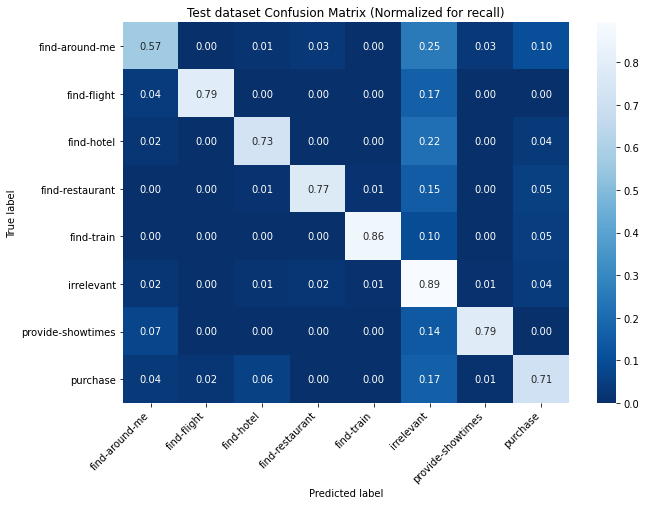

In [36]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

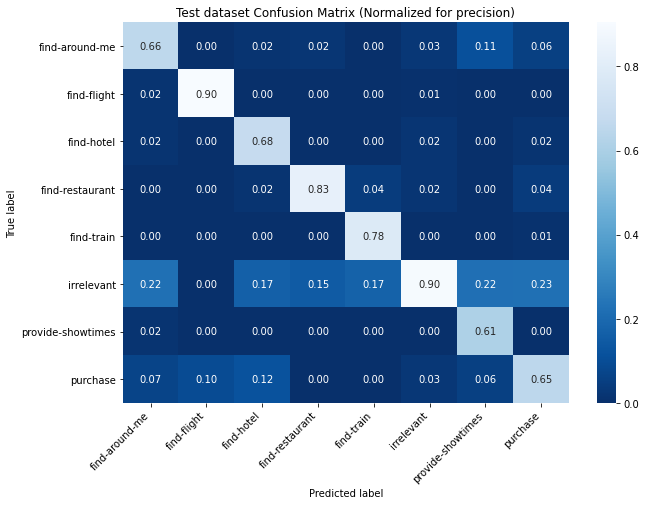

In [37]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On constate en utilisant cette classification hiérarchique les performances dans l'ensemble ne sont, encore une fois, pas très différentes. Sur plusieurs exécutions, nous observions parfois un meilleur recall ou une meilleur précision mais ce n'est pas une tendance générale et systématique. Nous pensons donc que cela découle seulement de l'aléatoire associé à l'entrainement ("Lottery Ticket Hypothesis").